# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Finding-HIF-1-direct-target-candidates" data-toc-modified-id="Finding-HIF-1-direct-target-candidates-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Finding HIF-1 direct target candidates</a></div><div class="lev1 toc-item"><a href="#vhl-1-dependent,-hif-1-independent,-genes" data-toc-modified-id="vhl-1-dependent,-hif-1-independent,-genes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span><em>vhl-1</em> dependent, <em>hif-1</em>-independent, genes</a></div><div class="lev1 toc-item"><a href="#egl-9-dependent,-non-hif-1-dependent,-genes" data-toc-modified-id="egl-9-dependent,-non-hif-1-dependent,-genes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><em>egl-9</em> dependent, non-<em>hif-1</em>-dependent, genes</a></div>

In this notebook, I will identify gene targets that are specifically regulated by each *egl-9*, *vhl-1*, and *hif-1*. I define a specific regulatory node to mean the node that is the nearest regulatory node to these targets out of the subset of genes we have mutants for. 

As usual, we first load up all the libraries

In [1]:
# important stuff:
import os
import pandas as pd
import numpy as np

# morgan
import morgan as morgan
import tissue_enrichment_analysis as tea
import epistasis as epi
import genpy
import gvars

# Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# Magic function to make matplotlib inline;
%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
q = 0.1
genvar = gvars.genvars()
tissue_df = tea.fetch_dictionary()
phenotype_df = pd.read_csv('../input/phenotype_ontology.csv')
go_df = pd.read_csv('../input/go_dictionary.csv')

In [3]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')
thomas.add_single_mutant(single_mutants)
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
sleuth_loc = '../sleuth_all_adjusted/kallisto/'

thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')
# load all the beta values for each genotype:
for file in os.listdir("../sleuth_all_adjusted/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)
thomas.filter_data()

In [4]:
frames = []
for key, df in thomas.beta.items():
    df['genotype'] = genvar.fancy_mapping[key]
    df['code'] = key
    frames += [df]
tidy_data = pd.concat(frames)
tidy_data = tidy_data[tidy_data.code != 'g']

# Finding HIF-1 direct target candidates

We are interested in identifying gene targets of HIF-1. In order to do this, I will decouple my data into two parts:
a `positive` dataframe, which contains all genes with $\beta$ values greater than 0
a `negative` dataframe, which contains all genes with $\beta$ values less than 0

I will also define a function called `collate`. This function takes in a list or a numpy array and returns a boolean indicator of what genes are in a specified dataframe. It's a lot shorter to define this function than it is to write the one-liner over and over again.

In [5]:
positive = tidy_data[tidy_data.b > 0]
negative = tidy_data[tidy_data.b < 0]

def collate(genes, df=tidy_data):
    """Finds what `genes` are in dataframe `df`"""
    return (df.target_id.isin(genes))

Next, I have to carefully set the conditions to define what a direct target of HIF-1 would look like. For this next part, I assume that HIF-1-OH is biologically dead

A direct target of HIF-1 must:
 1. Go **UP** every time that HIF-1 is disinhibited
 2. Go **DOWN** every time that HIF-1 completely disappears from the cell

Finding the overlap within the `positive` dataframe of the *rhy-1*, *vhl-1*, *egl-9* and *egl-9;vhl-1* genotypes gets us condition number one. On the other hand, finding the overlap within the `negative` dataframe of *hif-1* and *egl-9;hif-1* gets us condition 2. 

In [6]:
hif1_up = epi.find_overlap(['e', 'b', 'd', 'a'], positive)
hif1_down = epi.find_overlap(['c', 'f'], negative)

ind = (collate(hif1_up) & collate(hif1_down)) & (tidy_data.code == 'e')
print(len(tidy_data[ind].ens_gene.unique()))

tidy_data[ind].sort_values('qval')[['ext_gene', 'target_id','b', 'qval']]

3


,ext_gene,target_id,b,qval
19626,R08E5.3,R08E5.3,4.577666,0.000000e+00
31611,nit-1,ZK1058.6,3.369282,4.598481e-32
19618,NaN,R08E5.1.1,3.318619,1.164188e-09


We didn't get too many genes, so let's make the conditions less restrictive

A direct target of HIF-1 must:
 1. Go **UP** every time that HIF-1 is disinhibited

A direct target of HIF-1 must NOT:
 3. Go **UP** when HIF-1 completely disappears from the cell.

Condition (3) is a lot less restrictive than condition (2) above because it doesn't insist that HIF-1 direct targets need to go down when HIF-1 goes down. It just says they shouldn't go up. They could stay the same. Remember that 'staying the same' is a much larger category for the *hif-1* genotypes, because they only contain about 500 genes each.

In [7]:
hif1_up = epi.find_overlap(['e', 'b', 'd', 'a'], positive)
hif1minus_up = epi.find_overlap(['c', 'f'], positive)

# Make sure that the gene list includes hif-1 up, but does NOT include hif1minus_up
ind = collate(hif1_up) & (~collate(hif1minus_up)) & (tidy_data.code == 'e')
hypoxia_direct_targets = tidy_data[ind].sort_values('qval')[['ext_gene', 'ens_gene', 'target_id', 'b', 'qval']]
hypoxia_direct_targets.to_csv('../output/medium_confidence_hypoxia_targets_candidates.csv', index=False)

n = len(tidy_data[ind].ens_gene.unique())
message = 'There are {0} unique genes that are candidates for HIF-1 direct binding'
print(message.format(n))

There are 196 unique genes within the hypoxia response


Alright! Now we're talking. As a safety check, let's make a qPCR like plot to visualize our genes, and let's make sure they have the behavior we want:

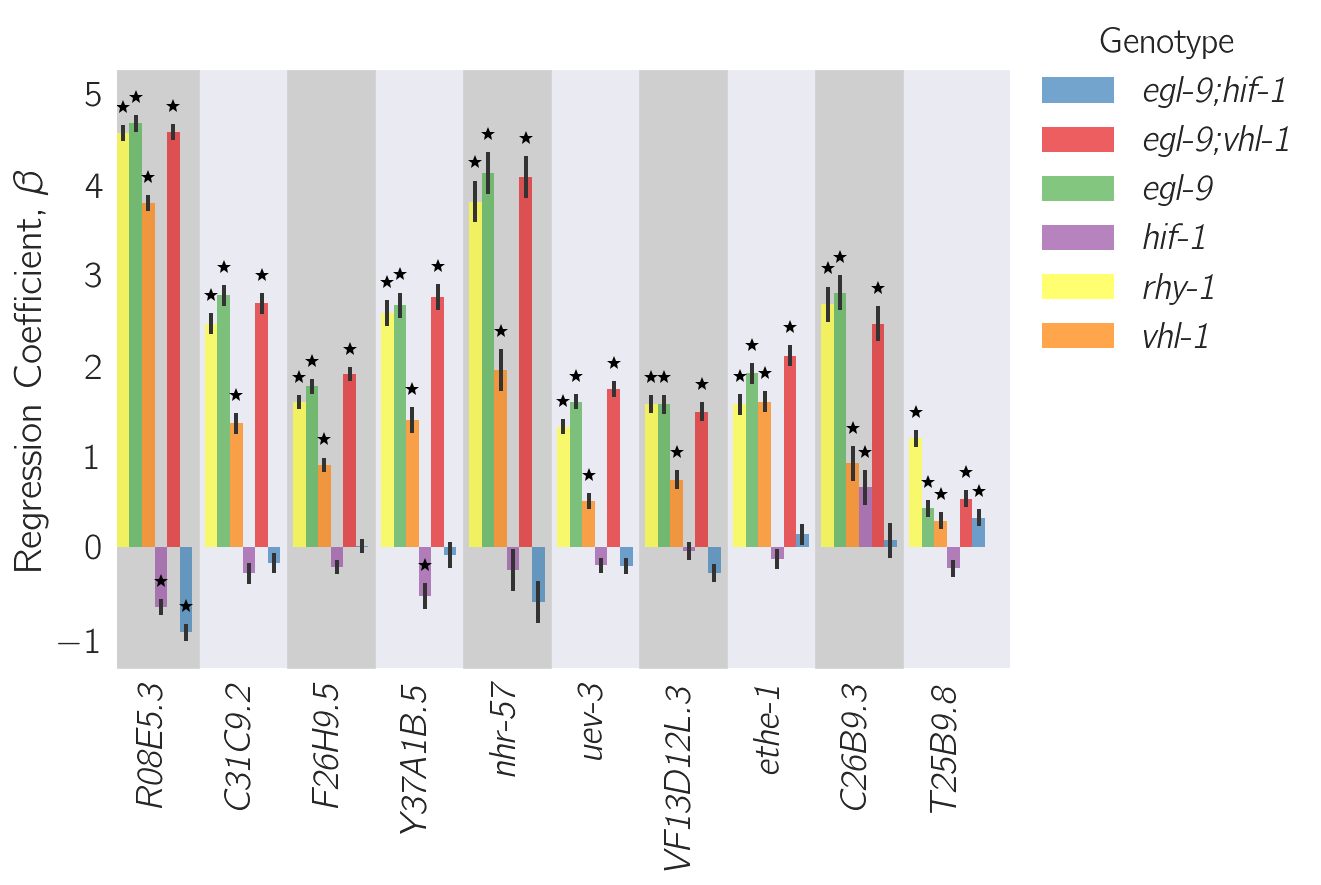

In [8]:
names = hypoxia_direct_targets.sort_values('qval').target_id.unique()[0:10]

name_sort = {}
for i, name in enumerate(names):
    name_sort[name] = i+1

plot_df = tidy_data[tidy_data.target_id.isin(names)].copy()
plot_df['order'] = plot_df.target_id.map(name_sort)
plot_df.sort_values('order', inplace=True)
plot_df.reset_index(inplace=True)  

genpy.qPCR_plot(plot_df, genvar.plot_order, genvar.plot_color, clustering='genotype', plotting_group='target_id',
                rotation=90)

,Tissue,Expected,Observed,Enrichment Fold Change,P value,Q value
44,immune system process GO:0002376,2.617142,15,5.731443,1.405882e-08,0.000004
99,carbohydrate binding GO:0030246,2.423876,13,5.363311,2.220483e-07,0.000030
63,peptidase activity GO:0008233,3.800895,13,3.420247,3.842854e-05,0.003459
29,pyridoxal phosphate binding GO:0030170,0.426795,4,9.372171,6.985112e-05,0.004715
154,actin binding GO:0003779,0.716694,5,6.976476,8.844723e-05,0.004776
71,serine hydrolase activity GO:0017171,0.885802,5,5.644603,2.826724e-04,0.012720
13,striated muscle dense body GO:0055120,0.756958,4,5.284309,1.018900e-03,0.034994
79,oxoacid metabolic process GO:0043436,2.955357,9,3.045317,9.072464e-04,0.034994
6,"oxidoreductase activity, acting on CH-OH group...",0.459006,3,6.535856,1.176656e-03,0.035300


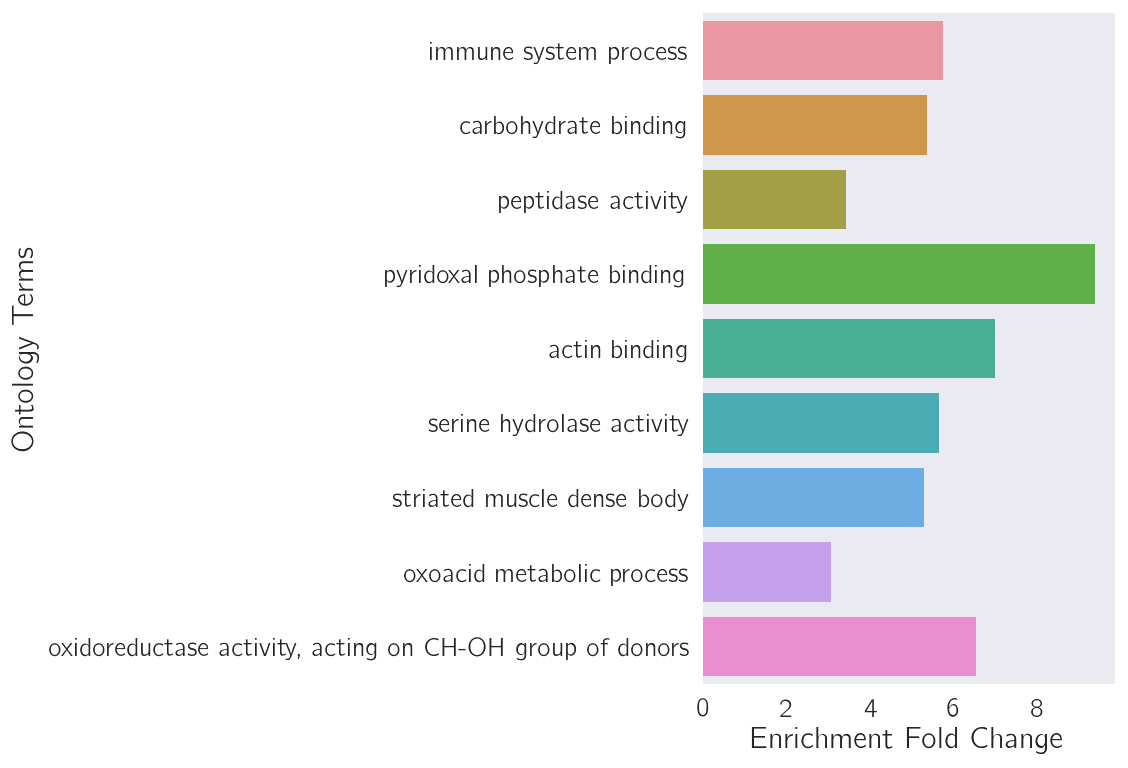

In [9]:
_ = tea.enrichment_analysis(hypoxia_direct_targets.ens_gene.unique(), go_df, show=False)
tea.plot_enrichment_results(_, analysis='go')
_

Uh oh. Why does C26B9.3 have a star over the purple bar, indicating that the *hif-1(lf)* genotype had increased levels of this gene's mRNA? Well, our set of conditions specified that both *hif-1* genotypes could not be up-regulated. We could make it even more stringent by making it an OR gate, but from visual inspection of the gene list, this wouldn't alter the result very much. 

# *vhl-1* dependent, *hif-1*-independent, genes

Finally, we can gate our settings to observe only *vhl-1*-dependent genes, by selecting only those genes that were present in the *vhl-1* and *egl-9;vhl-1* genotypes.

In [10]:
# find the genes that overlap between vhl1 and egl-9vhl-1 and change in same directiom
vhl_pos = epi.find_overlap(['d', 'a'], positive)
vhl_neg = epi.find_overlap(['d', 'a'], negative)
vhl = list(set(vhl_pos + vhl_neg))

# find genes that change in the same direction in vhl(-) and vhl(+ datasets)
same_vhl = []
for genotype in ['b', 'e', 'f', 'c']:
    same_vhl += epi.find_overlap(['d', 'a', genotype], positive)
    same_vhl += epi.find_overlap(['d', 'a', genotype], negative)

# put it all together:
ind = (collate(vhl)) & (~collate(same_vhl))
vhl_regulated = tidy_data[ind & (tidy_data.code == 'd')]

n = len(vhl_regulated.ens_gene.unique())
message = 'There are {0} genes that appear to be regulated in a hif-1-independent, vhl-1-dependent manner.'
print(message.format(n))

There are 46 genes that appear to be regulated in a hif-1-independent, vhl-1-dependent manner.


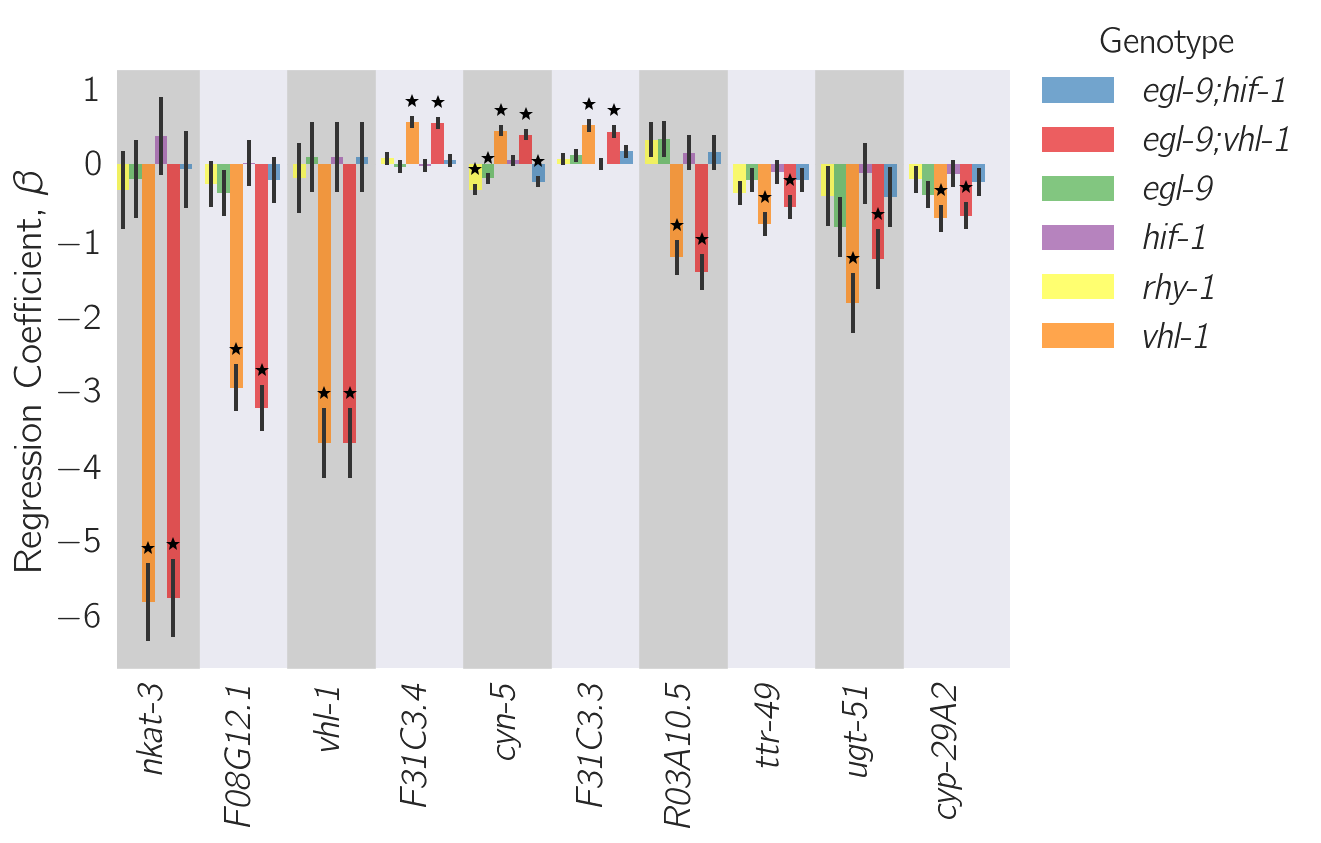

In [11]:
# begin plotting
names = vhl_regulated.sort_values('qval').target_id.unique()[0:10]
name_sort = {}
for i, name in enumerate(names):
    name_sort[name] = i+1

plot_df = tidy_data[tidy_data.target_id.isin(names)].copy()
plot_df['order'] = plot_df.target_id.map(name_sort)
plot_df.sort_values('order', inplace=True)
plot_df.reset_index(inplace=True)  

genpy.qPCR_plot(plot_df, genvar.plot_order, genvar.plot_color, clustering='genotype', plotting_group='target_id',
                rotation=90)
vhl_regulated[['ext_gene', 'ens_gene', 'target_id', 'b', 'qval']].to_csv('../output/vhl_1_regulated_genes.csv')

No enrichment was observed for these genes.

# *egl-9* dependent, non-*hif-1*-dependent, genes

I am also interested in knowing whether I can actually identify targets of *egl-9*. What are conditions on *egl-9* targets? Let's go ahead and see what we should do if HIF-1-OH is active.

Genotype | HIF-1| HIF-1OH| EGL-9
---------|------|--------|------
*hif-1(lf)*| HIF-1$\downarrow$| HIF-1OH$\downarrow$| EGL-9$\uparrow$ (?)
*egl-9(lf)*| HIF-1$\uparrow$| HIF-1OH$\downarrow$| EGL-9$\downarrow$
*rhy-1(lf)*| HIF-1$\uparrow$| HIF-1OH$\downarrow$| EGL-9$\downarrow$
*vhl-1(lf)*| HIF-1$\uparrow$| HIF-1OH$\uparrow$| EGL-9$\uparrow$
*egl-9(lf);hif-1*| HIF-1$\downarrow$| HIF-1OH$\downarrow$| EGL-9$\downarrow$
*egl-9(lf);vhl-1*| HIF-1$\uparrow$| HIF-1OH$\downarrow$| EGL-9$\downarrow$

OK. Sorry for the confusing table. The rule of the game is that we can combine rows as follows: For any entry, if the two arrows point in the same direction, that entry remains. If the two arrows point in different directions, they cancel. You can subtract rows, which amounts to flipping the sign.

If I add *egl-9*, *rhy-1* and *egl-9;hif-1*, I get:

Result | HIF-1| HIF-1OH| EGL-9| RHY-1
---------|------|--------|------|
Sum| -| HIF-1OH$\downarrow$| EGL-9$\downarrow$| NaN

Ack. We are almost there. But we are not quite there yet. We need to get rid of that pesky HIF-1OH. If I subtract the *hif-1* row, we can get rid of it.

This suggests a solution. Find the genes that are commonly regulated (in the same directions!) between *egl-9*, *rhy-1* and *egl-9;hif-1*. Next, find the genes that are regulated by *hif-1*. If the genes appear in the same list in the same direction in both lists, remove those genes. What is left should be the *egl-9* specific transcriptome


In [12]:
# genes that change in the same direction in egl, rhy and eglhif
egl_pos = epi.find_overlap(['e', 'b', 'f'], positive)
egl_neg = epi.find_overlap(['e', 'b', 'f'], negative)
egl = list(set(egl_pos + egl_neg))

cup = tidy_data[(tidy_data.code == 'c') & (tidy_data.b > 0)]
bdown = tidy_data[(tidy_data.code.isin(['e', 'b', 'f'])) & (tidy_data.b < 0)]
cdown = tidy_data[(tidy_data.code == 'c') & (tidy_data.b > 0)]
bup = tidy_data[tidy_data.code.isin(['e', 'b', 'f']) & (tidy_data.b < 0)]

antihif_1 = pd.concat([cup, bdown])
antihif_2 = pd.concat([cdown, bup])

antihif = []
for genotype in ['b', 'e', 'f']:
    temp = epi.find_overlap([genotype, 'c'], antihif_1)
    antihif += temp
    temp = epi.find_overlap([genotype, 'c'], antihif_2)
    antihif += temp

ind = collate(egl) & (collate(antihif)) & (~collate(same_vhl))

egl_regulated = tidy_data[ind & (tidy_data.code == 'b')]

In [13]:
n = egl_regulated.ens_gene.unique().shape[0]
print('There appear to be {0} egl-specific genes'.format(n))

There appear to be 0 egl-specific genes


We could not detect genes that had HIF-1 independent, EGL-9-dependent expression.